<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/6-deep-learning-for-text-and-sequences/5_advanced_use_of_recurrent_neural_networksipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced use of recurrent neural networks

**A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs.**

**With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point.**

For instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector(flatten) and processed in one go. Such networks are called **feedforward networks**.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

**Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in**.

A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: **it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop.**

The state of the RNN is reset between processing two different,
independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: **a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.**

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/recurrent-neural-network.png?raw=1' width='800'/>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Embedding, GRU
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Advanced use of recurrent neural networks

We will review three advanced techniques for improving the performance and generalization power of recurrent neural networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We will cover the following techniques:

* **Recurrent dropout, a specific, built-in way to use dropout to fight overfitting in recurrent layers.**
* **Stacking recurrent layers, to increase the representational power of the network** (at the cost of higher computational loads).
* **Bidirectional recurrent layers, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.**


## A temperature-forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

Let's take a look at the data:

In [3]:
# Download and uncompress the data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-05-25 09:20:15--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.186.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.186.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  41.1MB/s    in 0.3s    

2020-05-25 09:20:16 (41.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [4]:
# Inspecting the data of the Jena weather dataset
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values), as well as the following header:
```python
["Date Time",
"p (mbar)",
"T (degC)",
"Tpot (K)",
"Tdew (degC)",
"rh (%)",
"VPmax (mbar)",
"VPact (mbar)",
"VPdef (mbar)",
"sh (g/kg)",
"H2OC (mmol/mol)",
"rho (g/m**3)",
"wv (m/s)",
"max. wv (m/s)",
"wd (deg)"]
```

Now, convert all 420,551 lines of data into a Numpy array.

In [0]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

For instance, here is the plot of temperature (in degrees Celsius) over time:

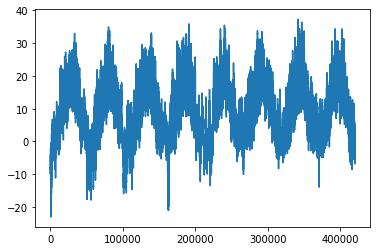

In [6]:
temp = float_data[:, 1]   # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points per day):

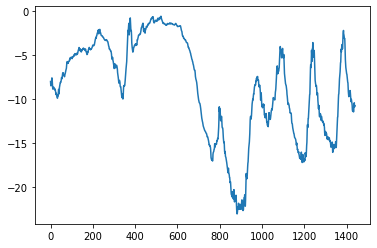

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is this timeseries predictable at a daily scale? Let's find out.

## Preparing the data

The exact formulation of our problem will be the following: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps?

We will use the following parameter values:

* lookback = 720, i.e. our observations will go back 5 days.
* steps = 6, i.e. our observations will be sampled at one data point per hour.
* delay = 144, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.

* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample N and sample N + 1 will have most of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

* **data**: The original array of floating point data, which we just normalized in the code snippet above.
* **lookback**: How many timesteps back should our input data go.
* **delay**: How many timesteps in the future should our target be.
* **min_index and max_index**: Indices in the data array that delimit which * timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
* **shuffle**: Whether to shuffle our samples or draw them in chronological order.
* **batch_size**: The number of samples per batch.
* **step**: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline

Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the temperature right now. 

Let's evaluate this approach, using the Mean Absolute Error metric (MAE). Mean Absolute Error is simply equal to:

```python
np.mean(np.abs(preds - targets))
```

Here's our evaluation loop:

In [11]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this number is not immediately interpretable. It translates to an average absolute error of 0.29 * temperature_std degrees Celsius, i.e. 2.57˚C. 

```python
celsius_mae = 0.29 * std[1]
```

That’s a fairly large average absolute error. Now the game is to use your knowledge of deep learning to do better.

## A basic machine-learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.9992 - val_loss: 0.5608
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3360 - val_loss: 0.2951
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2762 - val_loss: 0.2977
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2600 - val_loss: 0.3450
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2483 - val_loss: 0.3290
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2398 - val_loss: 0.3031
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2329 - val_loss: 0.3173
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2280 - val_loss: 0.3243
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2242 - val_loss: 0.3538
Epoch 

Let's display the loss curves for validation and training:

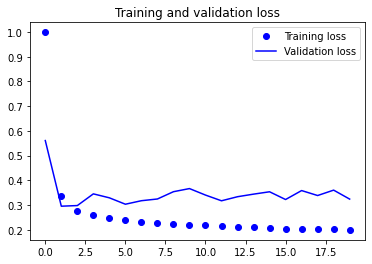

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. **The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where causality and order matter.** We will try a recurrent sequence processing model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the LSTM layer introduced in the previous section, we will use the GRU layer, developed by Cho et al. in 2014. **GRU layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM.** This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [14]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 30s 60ms/step - loss: 0.3094 - val_loss: 0.2741
Epoch 2/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2828 - val_loss: 0.2661
Epoch 3/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2788 - val_loss: 0.2638
Epoch 4/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2753 - val_loss: 0.2646
Epoch 5/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2688 - val_loss: 0.2632
Epoch 6/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2641 - val_loss: 0.2723
Epoch 7/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2615 - val_loss: 0.2613
Epoch 8/20
500/500 [==============================] - 31s 62ms/step - loss: 0.2575 - val_loss: 0.2603
Epoch 9/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2511 - val_loss: 0.2622
Epoch 10/20
500/500 [==============================] - 30s 60ms/step - loss: 0.245

Let look at our results:

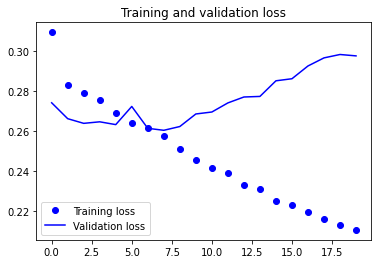

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. How to correctly apply dropout in recurrent networks, however, is not a trivial question. **It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization**. In 2015, Yarin Gal, as part of his Ph.D. thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. **Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units**. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs.

In [0]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 559s 1s/step - loss: 0.3289 - val_loss: 0.2848
Epoch 2/40
500/500 [==============================] - 559s 1s/step - loss: 0.3073 - val_loss: 0.2763
Epoch 3/40
500/500 [==============================] - 554s 1s/step - loss: 0.2979 - val_loss: 0.2688
Epoch 4/40
500/500 [==============================] - 563s 1s/step - loss: 0.2943 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 563s 1s/step - loss: 0.2898 - val_loss: 0.2679
Epoch 6/40
500/500 [==============================] - 557s 1s/step - loss: 0.2858 - val_loss: 0.2688
Epoch 7/40
500/500 [==============================] - 563s 1s/step - loss: 0.2849 - val_loss: 0.2679
Epoch 8/40
500/500 [==============================] - 559s 1s/step - loss: 0.2812 - val_loss: 0.2710
Epoch 9/40
500/500 [==============================] - 558s 1s/step - loss: 0.2765 - val_loss: 0.2720
Epoch 10/40
500/500 [==============================] - 563s 1s/step - loss: 0.2738 - val_lo

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best scores are not much lower than they were previously.

## Stacking recurrent layers

**Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network.** If you remember our description of the "universal machine learning workflow": **it is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle** (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). **As long as you are not overfitting too badly, then you are likely under-capacity.**

**Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks**: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers -- that's huge.

**To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True:**


In [0]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.2, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Let's take a look at our results:

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss improvement. This does have a non-negligible computational cost, though.
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this point.

## Using bidirectional RNNs